# RMIA Implementation and Experiment

This notebook implements the **Ratio Membership Inference Attack (RMIA)** as described in the paper ["Low-Cost High-Power Membership Inference Attacks"](https://arxiv.org/html/2312.03262v3#S2).

## 1. Concept and Objective
**Objective**: To determine whether a specific data point (an image $x$ from CIFAR-10) was part of the training set of a target model (ResNet-18).

**Key Idea**: RMIA improves upon simple loss-based attacks by using a **Likelihood Ratio (LR)** test. It compares the probability of the data under the target model against its probability under a "reference" model (which represents the general population or "world" distribution).

### Core Formulas
1.  **Likelihood Ratio (LR)**:
    $$
    LR(x) = \frac{P(x | \theta_{target})}{P(x | \theta_{ref})}
    $$
    Where:
    *   $P(x | \theta_{target})$ is the confidence of the target model on the true class of $x$.
    *   $P(x | \theta_{ref})$ is the confidence of the reference model (trained on disjoint data) on $x$.

2.  **RMIA Score**:
    The attack doesn't just look at the raw LR. It checks how "exceptional" the LR of $x$ is compared to the LRs of random samples $z$ from the population.
    $$
    Score_{RMIA}(x) = P_{z \sim \mathcal{Z}}(LR(x) > LR(z))
    $$
    This is empirically calculated as the fraction of population samples $z$ that have a lower Likelihood Ratio than $x$ (i.e., the percentile rank).

## 2. Implementation Steps for RMIA with 1 reference model

1.  **Data Preparation**: Split CIFAR-10 into four disjoint sets:
    *   **Target Members (12.5k)**: Used to train the Target Model.
    *   **Reference Members (12.5k)**: Used to train the Reference Model.
    *   **Population $Z$ (12.5k)**: Used to compute the normalization statistics for the RMIA score.
    *   **Non-Members (10k)**: The official CIFAR-10 test set, used as the "ground truth" non-members for evaluation.

2.  **Model Training**:
    *   Define a ResNet-18 modified for CIFAR-10 (small kernel size, no initial maxpool).
    *   Train `Target Model` on Target Members.
    *   Train `Reference Model` on Reference Members.
    *   *Note: Weights are saved/loaded to avoid re-training.*

3.  **Attack Execution**:
    *   Calculate $LR(x) = \frac{P(x | \theta_{target})}{P(x | \theta_{ref})}$ : Pass **Target Members** through both models (target and reference models)
    *   Calculate $LR(z) = \frac{P(z | \theta_{target})}{P(z | \theta_{ref})}$ : Pass **Population ($Z$)**  through both models (target and reference models)
    *   Calculate RMIA Score: For each $x$, count how many $z$'s have a smaller ratio than it (calculate the percentile)
    *   Threshold: If Score > $\beta$ (e.g., 0.5), classify as Member

4.  **Evaluation**:
    *   Compute the Receiver Operating Characteristic (ROC) curve.
    *   Calculate Area Under the Curve (AUC) to measure attack performance (0.5 = random, 1.0 = perfect).

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import copy
import argparse
import random

# --- 0. Seed for Reproducibility ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")


In [11]:
# --- 1. Model Definition (ResNet-18 adapted for CIFAR-10) ---
# Standard ResNet18 is designed for ImageNet (224x224).
# For CIFAR-10 (32x32), we need to adjust the initial layers to avoid excessive downsampling.

def get_resnet18_cifar10(num_classes=10):
    # Load standard ResNet18
    model = torchvision.models.resnet18(weights=None)
    
    # Modify the first convolution layer
    # Original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # CIFAR-10: Kernel size 3, stride 1, padding 1 is better to preserve spatial dim
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Remove the first MaxPool layer
    # Original: nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # CIFAR-10: We don't want to downsample this early
    model.maxpool = nn.Identity()
    
    # Modify the fully connected layer for 10 classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

# --- 2. Helper Functions ---

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

def train_model(model, train_loader, test_loader=None, epochs=20, lr=0.1, device="cpu", model_name="model"):
    print(f"Training {model_name} on {device}...")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_acc = 100.*correct/total
        scheduler.step()

        test_acc_str = ""
        if test_loader:
            model.eval()
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    test_total += labels.size(0)
                    test_correct += predicted.eq(labels).sum().item()
            test_acc = 100.*test_correct/test_total
            test_acc_str = f" Test Acc: {test_acc:.2f}%"

        print(f"  Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} Train Acc: {train_acc:.2f}%{test_acc_str}")
    
    model.eval()
    return model

def get_probabilities(model, loader, device):
    """
    Returns the probabilities of the TRUE class for each sample.
    """
    model.eval()
    model.to(device)
    probs = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            softmax_scores = torch.softmax(outputs, dim=1)
            
            # Select the probability of the true class
            true_class_probs = softmax_scores.gather(1, labels.view(-1, 1)).squeeze()
            probs.extend(true_class_probs.cpu().numpy())
            
    return np.array(probs)

In [12]:
# --- 3. Main Experiment ---

set_seed(42)

data_dir = "./data"
epochs = 20
batch_size = 128

device = get_device()
print(f"Using device: {device}")

# Data Preparation
print("Preparing Data...")
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load Full CIFAR-10
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
# Use testset for evaluation/non-members
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

# Split Trainset
# Total 50k. 
# Target Members: 12.5k
# Reference Train: 12.5k (To train the reference model)
# Population Z: 12.5k (Used for RMIA normalization)
# Unused: 12.5k

indices = np.arange(len(trainset))
np.random.shuffle(indices)

idx_target = indices[:12500]
idx_ref = indices[12500:25000]
idx_pop = indices[25000:37500]

# We will use the official test set as "Non-Members" for the attack evaluation
# to ensure they are strictly out-of-distribution of training.

# Create Subsets
# Note: For evaluation (computing probs), we should use transform_test (no aug)
# So we need a version of trainset with test transforms
trainset_eval = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=False, transform=transform_test)

ds_target_train = Subset(trainset, idx_target)
ds_ref_train = Subset(trainset, idx_ref)

ds_target_eval = Subset(trainset_eval, idx_target) # Members (evaluated without aug)
ds_pop_eval = Subset(trainset_eval, idx_pop)       # Population Z
ds_non_member_eval = testset                       # Non-Members (Test set)

# Loaders: no shuffle to get the same result in different runs
dl_target_train = DataLoader(ds_target_train, batch_size=batch_size, shuffle=False)
dl_ref_train = DataLoader(ds_ref_train, batch_size=batch_size, shuffle=False)

dl_target_eval = DataLoader(ds_target_eval, batch_size=batch_size, shuffle=False)
dl_non_member_eval = DataLoader(ds_non_member_eval, batch_size=batch_size, shuffle=False)
dl_pop_eval = DataLoader(ds_pop_eval, batch_size=batch_size, shuffle=False)

Random seed set to 42
Using device: cpu
Preparing Data...


c:\Users\Administratör\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [13]:

# --- Train Target Model ---
print("\n--- Training Target Model ---")
target_model = get_resnet18_cifar10()
target_model_path = "target_model.pth"
if os.path.exists(target_model_path):
    print(f"Loading Target Model from {target_model_path}...")
    target_model.load_state_dict(torch.load(target_model_path, map_location=device))
    target_model.to(device)
    target_model.eval()
else:
    target_model = train_model(target_model, dl_target_train, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Target Model")
    torch.save(target_model.state_dict(), target_model_path)
    print(f"Saved Target Model to {target_model_path}")

# --- Train Reference Model ---
print("\n--- Training Reference Model ---")
# In a real attack, you might use multiple reference models. We use 1 for demonstration.
ref_model = get_resnet18_cifar10()
ref_model_path = "ref_model.pth"
if os.path.exists(ref_model_path):
    print(f"Loading Reference Model from {ref_model_path}...")
    ref_model.load_state_dict(torch.load(ref_model_path, map_location=device))
    ref_model.to(device)
    ref_model.eval()
else:
    ref_model = train_model(ref_model, dl_ref_train, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Reference Model")
    torch.save(ref_model.state_dict(), ref_model_path)
    print(f"Saved Reference Model to {ref_model_path}")



--- Training Target Model ---
Loading Target Model from target_model.pth...

--- Training Reference Model ---
Loading Reference Model from ref_model.pth...


In [14]:

# --- Perform RMIA Attack ---
print("\n--- Computing Probabilities ---")

# P(x | theta_target)
prob_target_members = get_probabilities(target_model, dl_target_eval, device)
print("prob_target_members", prob_target_members.size)
# P(x'| theta_target)
prob_target_non_members = get_probabilities(target_model, dl_non_member_eval, device)
print("prob_target_non_members", prob_target_non_members.size)
# P(z | theta_target)
prob_target_z = get_probabilities(target_model, dl_pop_eval, device)
print("prob_target_z", prob_target_z.size)

# P(x | theta_ref) -> approximates P(x)
prob_ref_members = get_probabilities(ref_model, dl_target_eval, device)
print("prob_ref_members", prob_ref_members.size)
# P(x' | theta_ref)
prob_ref_non_members = get_probabilities(ref_model, dl_non_member_eval, device)
print("prob_ref_non_members", prob_ref_non_members.size)
# P(z | theta_ref)
prob_ref_z = get_probabilities(ref_model, dl_pop_eval, device)
print("prob_ref_z", prob_ref_z.size)



--- Computing Probabilities ---
prob_target_members 12500
prob_target_non_members 10000
prob_target_z 12500
prob_ref_members 12500
prob_ref_non_members 10000
prob_ref_z 12500


In [15]:

print("\n--- Calculating RMIA Scores ---")

# Calculate Likelihood Ratios: LR(x) = P(x|Target) / P(x|Ref)
# Adding epsilon to avoid division by zero
epsilon = 1e-10
# LR(x)
ratio_members = prob_target_members / (prob_ref_members + epsilon)
# LR(z)
ratio_z = prob_target_z / (prob_ref_z + epsilon)
# LR(non-member)
ratio_non_members = prob_target_non_members / (prob_ref_non_members + epsilon)

# RMIA Score(x) = Pr( LR(x) > LR(z) )
# For each x, we calculate what fraction of z samples have a lower ratio.
# This is equivalent to the rank or percentile.

def calculate_rmia_score(ratios_eval, ratios_population):
    scores = []
    # Sort population ratios for binary search (faster) or just broadcasting
    # Using broadcasting for clarity
    ratios_population = np.array(ratios_population)
    for r in ratios_eval:
        # Fraction of population ratios that are strictly smaller than r
        # (or <=, depending on strictness. The paper uses > gamma)
        score = np.mean(r > ratios_population)
        scores.append(score)
    return np.array(scores)
# list of RMIA score: 12500 scores, one for each image in the member set
rmia_scores_members = calculate_rmia_score(ratio_members, ratio_z)
print("rmia_scores_members", rmia_scores_members.size)
# list of RMIA score: 10000 scores, one for each image in the non-member set
rmia_scores_non_members = calculate_rmia_score(ratio_non_members, ratio_z)
print("rmia_scores_non_members", rmia_scores_non_members.size)



--- Calculating RMIA Scores ---
rmia_scores_members 12500
rmia_scores_non_members 10000


y_true 22500
y_scores 22500
fpr 6406
tpr 6406
thresholds 6406

RMIA Attack Results:
AUC: 0.7020
ROC curve saved to rmia_roc_curve.png


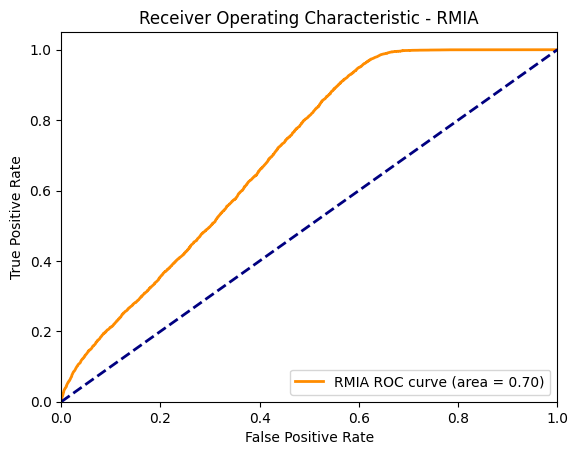

In [16]:

# --- Evaluation ---
# ground truth: a list of 12500+10000 with 12500 value of 1 for members and 10000 value of 0 for non-member
y_true = np.concatenate([np.ones_like(rmia_scores_members), np.zeros_like(rmia_scores_non_members)])
print("y_true", y_true.size)
# RMIA scores: 12500 scores for members and 10000 score for non-members
y_scores = np.concatenate([rmia_scores_members, rmia_scores_non_members])
print("y_scores", y_scores.size)
# no constant threshold but each of the socre is used as a potential threshold
# for each potential threshold, 
#   classify x is a member if y_score(x) > the threshold and vice versa.
#   compare the classification result with the y_true, count no of TP, FP, TN, FN
#   calculate the TPR = TP/(TP+FN) and FPR = FP/(FP+TN)
# the roc_curve fnc performs all above tasks for the moving thresholds
#   fpr and tpr is a list of fpr and tpr with the size of 12500+10000 each
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print("fpr", fpr.size)
print("tpr", tpr.size)
print("thresholds", thresholds.size)
roc_auc = auc(fpr, tpr)

print(f"\nRMIA Attack Results:")
print(f"AUC: {roc_auc:.4f}")

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'RMIA ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - RMIA')
plt.legend(loc="lower right")
plt.savefig('rmia_roc_curve.png')
print("ROC curve saved to rmia_roc_curve.png")

## Extended experiment: RMIA with 2 reference models


--- Training Reference Model 2 ---
Loading Reference Model 2 from ref_model_2.pth...

--- Computing Probabilities for Ref Model 2 ---

--- Calculating RMIA Scores (2 Ref Models) ---

RMIA Attack Results (2 Ref Models):
AUC: 0.7390
Comparison ROC curve saved to rmia_roc_comparison.png


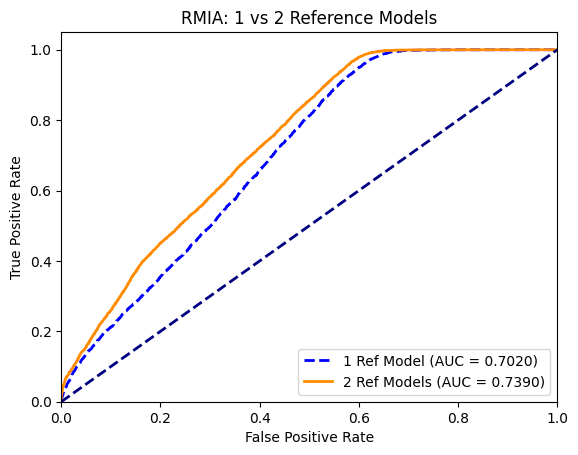

In [17]:
# --- 4. Extended Experiment: 2 Reference Models ---

# 4.1 Data for Reference Model 2
# We use the remaining unused training data (indices 37500 to 50000)
idx_ref2 = indices[37500:]
ds_ref2_train = Subset(trainset, idx_ref2)
dl_ref2_train = DataLoader(ds_ref2_train, batch_size=batch_size, shuffle=False)

# 4.2 Train Reference Model 2
print("\n--- Training Reference Model 2 ---")
ref_model_2 = get_resnet18_cifar10()
ref_model_2_path = "ref_model_2.pth"

if os.path.exists(ref_model_2_path):
    print(f"Loading Reference Model 2 from {ref_model_2_path}...")
    ref_model_2.load_state_dict(torch.load(ref_model_2_path, map_location=device))
    ref_model_2.to(device)
    ref_model_2.eval()
else:
    ref_model_2 = train_model(ref_model_2, dl_ref2_train, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Reference Model 2")
    torch.save(ref_model_2.state_dict(), ref_model_2_path)
    print(f"Saved Reference Model 2 to {ref_model_2_path}")

# 4.3 Compute Probabilities for Ref Model 2
print("\n--- Computing Probabilities for Ref Model 2 ---")
prob_ref2_members = get_probabilities(ref_model_2, dl_target_eval, device)
prob_ref2_non_members = get_probabilities(ref_model_2, dl_non_member_eval, device)
prob_ref2_z = get_probabilities(ref_model_2, dl_pop_eval, device)

# 4.4 Ensemble Reference Probabilities (Average)
# P(x | theta_ref_ensemble) = (P(x | theta_ref1) + P(x | theta_ref2)) / 2
prob_ref_members_ens = (prob_ref_members + prob_ref2_members) / 2
prob_ref_non_members_ens = (prob_ref_non_members + prob_ref2_non_members) / 2
prob_ref_z_ens = (prob_ref_z + prob_ref2_z) / 2

# 4.5 Calculate New Ratios
# LR(x) = P(x|Target) / P(x|Ref_Ensemble)
ratio_members_ens = prob_target_members / (prob_ref_members_ens + epsilon)
ratio_non_members_ens = prob_target_non_members / (prob_ref_non_members_ens + epsilon)
ratio_z_ens = prob_target_z / (prob_ref_z_ens + epsilon)

# 4.6 Calculate RMIA Scores
print("\n--- Calculating RMIA Scores (2 Ref Models) ---")
rmia_scores_members_ens = calculate_rmia_score(ratio_members_ens, ratio_z_ens)
rmia_scores_non_members_ens = calculate_rmia_score(ratio_non_members_ens, ratio_z_ens)

# 4.7 Evaluation
y_true_ens = np.concatenate([np.ones_like(rmia_scores_members_ens), np.zeros_like(rmia_scores_non_members_ens)])
y_scores_ens = np.concatenate([rmia_scores_members_ens, rmia_scores_non_members_ens])

fpr_ens, tpr_ens, thresholds_ens = roc_curve(y_true_ens, y_scores_ens)
roc_auc_ens = auc(fpr_ens, tpr_ens)

print(f"\nRMIA Attack Results (2 Ref Models):")
print(f"AUC: {roc_auc_ens:.4f}")

# Plot Comparison
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, linestyle='--', label=f'1 Ref Model (AUC = {roc_auc:.4f})')
plt.plot(fpr_ens, tpr_ens, color='darkorange', lw=2, label=f'2 Ref Models (AUC = {roc_auc_ens:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RMIA: 1 vs 2 Reference Models')
plt.legend(loc="lower right")
plt.savefig('rmia_roc_comparison.png')
print("Comparison ROC curve saved to rmia_roc_comparison.png")

# Extended Experiment: RMIA on Class Imbalanced Dataset

In this experiment, we evaluate the effectiveness of RMIA when the **both the target model and the referenced model** is trained on a class-imbalanced dataset.

**Steps:**
1.  **Create Imbalanced Dataset**: Modify the CIFAR-10 training set to have imbalanced classes. We keep 10% of images belong to class 0-4
2.  **Train Target Model**: Train a ResNet-18 model on the subset of imbalanced dataset for the target model training.
3.  **Train Reference Model**: Train a reference model on the subset of imbalanced dataset for the reference model training
4.  **Perform RMIA**: Execute the attack using the target and reference model.
5.  **Evaluate**: Compute the AUC of the ROC curve.


=== Starting Imbalanced Dataset Experiment: Both target and refernce model is trained on imbalanced dataset ===
Creating Imbalanced Datasets...
Original Target Size: 12500, Imbalanced: 6915
Original Ref Size: 12500, Imbalanced: 6892
Original Pop Size: 12500, Imbalanced: 6878

--- Training Target Model (Imbalanced) ---
Loading Imbalanced Target Model from target_model_imb.pth...

--- Training Reference Model (Imbalanced) ---
Loading Imbalanced Reference Model from ref_model_imb.pth...

--- Computing Probabilities (Imbalanced) ---

--- Calculating RMIA Scores (Imbalanced) ---

RMIA Attack Results (Imbalanced Dataset):
AUC: 0.5792
Imbalanced ROC curve saved to rmia_roc_imbalanced.png


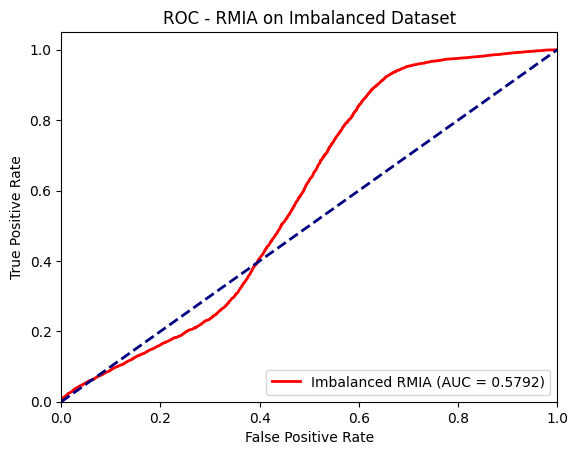

In [19]:
# --- 5. Imbalanced Dataset Experiment ---

print("\n=== Starting Imbalanced Dataset Experiment: Both target and refernce model is trained on imbalanced dataset ===")

# 5.1 Create Imbalanced Dataset
# We will create an imbalance by keeping only 10% of data for classes 0-4
# and keeping 100% of data for classes 5-9.

def get_imbalanced_indices(dataset, indices, imbalance_ratio=0.1, minority_classes=[0, 1, 2, 3, 4]):
    imbalanced_indices = []
    # Map indices to targets to filter
    targets = np.array(dataset.targets)
    
    for idx in indices:
        label = targets[idx]
        if label in minority_classes:
            # Keep with probability imbalance_ratio
            if np.random.rand() < imbalance_ratio:
                imbalanced_indices.append(idx)
        else:
            # Keep all majority class samples
            imbalanced_indices.append(idx)
            
    return np.array(imbalanced_indices)

# Reuse the original indices split (Target, Ref, Population)
# Apply imbalance filtering to each set

print("Creating Imbalanced Datasets...")
idx_target_imb = get_imbalanced_indices(trainset, idx_target)
idx_ref_imb = get_imbalanced_indices(trainset, idx_ref)

# Note: The population Z should also reflect the world distribution.
# If we assume the world is imbalanced, we filter Z too.
idx_pop_imb = get_imbalanced_indices(trainset, idx_pop)

print(f"Original Target Size: {len(idx_target)}, Imbalanced: {len(idx_target_imb)}")
print(f"Original Ref Size: {len(idx_ref)}, Imbalanced: {len(idx_ref_imb)}")
print(f"Original Pop Size: {len(idx_pop)}, Imbalanced: {len(idx_pop_imb)}")

# Create Subsets
ds_target_train_imb = Subset(trainset, idx_target_imb)
ds_ref_train_imb = Subset(trainset, idx_ref_imb)

# Evaluation Subsets (Member/Non-Member/Population)
ds_target_eval_imb = Subset(trainset_eval, idx_target_imb)
ds_pop_eval_imb = Subset(trainset_eval, idx_pop_imb)
# Non-members remain the same (Test set), assuming we want to test membership
# of the general population (which might be balanced or not, but test set is balanced).
# However, typically non-members should be from the same distribution.
# For simplicity, we keep the original balanced test set as non-members.

# Loaders
dl_target_train_imb = DataLoader(ds_target_train_imb, batch_size=batch_size, shuffle=True)
dl_ref_train_imb = DataLoader(ds_ref_train_imb, batch_size=batch_size, shuffle=True)

dl_target_eval_imb = DataLoader(ds_target_eval_imb, batch_size=batch_size, shuffle=False)
dl_pop_eval_imb = DataLoader(ds_pop_eval_imb, batch_size=batch_size, shuffle=False)
# dl_non_member_eval is already defined (balanced test set), 
# we dont imbalance it since the experiment is to trained the model on imbalance dataset and show its weakness with the world of balance dataset

# 5.2 Train Models on Imbalanced Data

# Train Target Model (Imbalanced)
print("\n--- Training Target Model (Imbalanced) ---")
target_model_imb = get_resnet18_cifar10()
target_model_imb_path = "target_model_imb.pth"

if os.path.exists(target_model_imb_path):
    print(f"Loading Imbalanced Target Model from {target_model_imb_path}...")
    target_model_imb.load_state_dict(torch.load(target_model_imb_path, map_location=device))
    target_model_imb.to(device)
    target_model_imb.eval()
else:
    target_model_imb = train_model(target_model_imb, dl_target_train_imb, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Target Model (Imb)")
    torch.save(target_model_imb.state_dict(), target_model_imb_path)
    print(f"Saved Imbalanced Target Model to {target_model_imb_path}")

# Train Reference Model (Imbalanced)
print("\n--- Training Reference Model (Imbalanced) ---")
ref_model_imb = get_resnet18_cifar10()
ref_model_imb_path = "ref_model_imb.pth"

if os.path.exists(ref_model_imb_path):
    print(f"Loading Imbalanced Reference Model from {ref_model_imb_path}...")
    ref_model_imb.load_state_dict(torch.load(ref_model_imb_path, map_location=device))
    ref_model_imb.to(device)
    ref_model_imb.eval()
else:
    ref_model_imb = train_model(ref_model_imb, dl_ref_train_imb, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Reference Model (Imb)")
    torch.save(ref_model_imb.state_dict(), ref_model_imb_path)
    print(f"Saved Imbalanced Reference Model to {ref_model_imb_path}")

# 5.3 Perform RMIA (Imbalanced)
print("\n--- Computing Probabilities (Imbalanced) ---")

# P(x | theta_target)
prob_target_members_imb = get_probabilities(target_model_imb, dl_target_eval_imb, device)
prob_target_non_members_imb = get_probabilities(target_model_imb, dl_non_member_eval, device)
prob_target_z_imb = get_probabilities(target_model_imb, dl_pop_eval_imb, device)

# P(x | theta_ref)  Here we evaluate the RMIA with reference model also trained on imbalanced dataset.
prob_ref_members_imb = get_probabilities(ref_model_imb, dl_target_eval_imb, device)
prob_ref_non_members_imb = get_probabilities(ref_model_imb, dl_non_member_eval, device)
prob_ref_z_imb = get_probabilities(ref_model_imb, dl_pop_eval_imb, device)


# Calculate Ratios
ratio_members_imb = prob_target_members_imb / (prob_ref_members_imb + epsilon)
ratio_non_members_imb = prob_target_non_members_imb / (prob_ref_non_members_imb + epsilon)
ratio_z_imb = prob_target_z_imb / (prob_ref_z_imb + epsilon)

# Calculate Scores
print("\n--- Calculating RMIA Scores (Imbalanced) ---")
rmia_scores_members_imb = calculate_rmia_score(ratio_members_imb, ratio_z_imb)
rmia_scores_non_members_imb = calculate_rmia_score(ratio_non_members_imb, ratio_z_imb)

# 5.4 Evaluation
y_true_imb = np.concatenate([np.ones_like(rmia_scores_members_imb), np.zeros_like(rmia_scores_non_members_imb)])
y_scores_imb = np.concatenate([rmia_scores_members_imb, rmia_scores_non_members_imb])

fpr_imb, tpr_imb, thresholds_imb = roc_curve(y_true_imb, y_scores_imb)
roc_auc_imb = auc(fpr_imb, tpr_imb)

print(f"\nRMIA Attack Results (Imbalanced Dataset):")
print(f"AUC: {roc_auc_imb:.4f}")

# Plot ROC
plt.figure()
plt.plot(fpr_imb, tpr_imb, color='red', lw=2, label=f'Imbalanced RMIA (AUC = {roc_auc_imb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - RMIA on Imbalanced Dataset')
plt.legend(loc='lower right')
plt.savefig('rmia_roc_imbalanced.png')
print("Imbalanced ROC curve saved to rmia_roc_imbalanced.png")

# Extended Experiment: RMIA on Class Imbalanced Dataset

In this experiment, we evaluate the effectiveness of RMIA when the **ONLY the target model** is trained on a class-imbalanced dataset.

**Steps:**
1.  **Create Imbalanced Dataset**: Modify the CIFAR-10 training set to have imbalanced classes. We keep 10% of images belong to class 0-4
2.  **Train Target Model**: Train a ResNet-18 model on the subset of imbalanced dataset for the target model training.
3.  **Train Reference Model**: Train a reference model on the subset of imbalanced dataset for the reference model training
4.  **Perform RMIA**: Execute the attack using the target and reference model.
5.  **Evaluate**: Compute the AUC of the ROC curve.


=== Starting Imbalanced Dataset Experiment. Ony target model is trained on imbalanced dataset ===

--- Computing Probabilities (Imbalanced) ---

--- Calculating RMIA Scores (Imbalanced) ---

RMIA Attack Results (Imbalanced Dataset):
AUC: 0.7111
Imbalanced ROC curve saved to rmia_roc_imbalanced.png


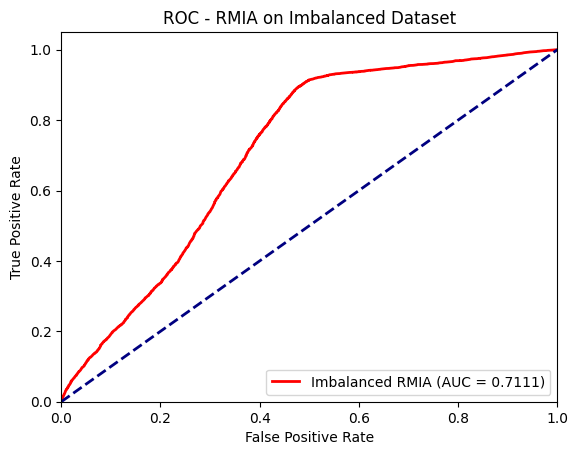

In [20]:
print("\n=== Starting Imbalanced Dataset Experiment. Ony target model is trained on imbalanced dataset ===")

# 5.3 Perform RMIA (Imbalanced)
print("\n--- Computing Probabilities (Imbalanced) ---")

# P(x | theta_target)
prob_target_members_imb = get_probabilities(target_model_imb, dl_target_eval_imb, device)
prob_target_non_members_imb = get_probabilities(target_model_imb, dl_non_member_eval, device)
prob_target_z_imb = get_probabilities(target_model_imb, dl_pop_eval_imb, device)

# P(x | theta_ref)  Here we evaluate the RMIA with reference model that was trained on balance dataset.
prob_ref_members_imb = get_probabilities(ref_model, dl_target_eval_imb, device)
prob_ref_non_members_imb = get_probabilities(ref_model, dl_non_member_eval, device)
prob_ref_z_imb = get_probabilities(ref_model_imb, dl_pop_eval_imb, device)

# Calculate Ratios
ratio_members_imb = prob_target_members_imb / (prob_ref_members_imb + epsilon)
ratio_non_members_imb = prob_target_non_members_imb / (prob_ref_non_members_imb + epsilon)
ratio_z_imb = prob_target_z_imb / (prob_ref_z_imb + epsilon)

# Calculate Scores
print("\n--- Calculating RMIA Scores (Imbalanced) ---")
rmia_scores_members_imb = calculate_rmia_score(ratio_members_imb, ratio_z_imb)
rmia_scores_non_members_imb = calculate_rmia_score(ratio_non_members_imb, ratio_z_imb)

# 5.4 Evaluation
y_true_imb = np.concatenate([np.ones_like(rmia_scores_members_imb), np.zeros_like(rmia_scores_non_members_imb)])
y_scores_imb = np.concatenate([rmia_scores_members_imb, rmia_scores_non_members_imb])

fpr_imb, tpr_imb, thresholds_imb = roc_curve(y_true_imb, y_scores_imb)
roc_auc_imb = auc(fpr_imb, tpr_imb)

print(f"\nRMIA Attack Results (Imbalanced Dataset):")
print(f"AUC: {roc_auc_imb:.4f}")

# Plot ROC
plt.figure()
plt.plot(fpr_imb, tpr_imb, color='red', lw=2, label=f'Imbalanced RMIA (AUC = {roc_auc_imb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - RMIA on Imbalanced Dataset')
plt.legend(loc='lower right')
plt.savefig('rmia_roc_imbalanced.png')
print("Imbalanced ROC curve saved to rmia_roc_imbalanced.png")